# NorthWest Corner Method

In [27]:
import copy

grid = [[3, 1, 7, 4], [2, 6, 5, 9], [8, 3, 3, 2]]  # table
supply = [300, 400, 500]  # supply
demand = [250, 350, 400, 200]  # demand


In [28]:
import tracemalloc


In [29]:
def northwest_corner(g, s, d):
    # делаем копии данных, чтобы не изменять изначальные
    grid = copy.deepcopy(g)
    supply = list(s)
    demand = list(d)

    startR = 0  # стартовая строка
    startC = 0  # стартовая колонка
    ans = 0
    # цикл выполняется до тех пор, пока не достигнет правого нижнего угла
    counter = 0

    tracemalloc.start()

    while (startR != len(grid) and startC != len(grid[0])):
        counter += 1
        # если спрос превышает предложение
        if (supply[startR] <= demand[startC]):
            ans += supply[startR] * grid[startR][startC]
            # вычесть величину предложения из величины спроса
            demand[startC] -= supply[startR]
            startR += 1
        # если предложение превышает спрос
        else:
            ans += demand[startC] * grid[startR][startC]
            # вычесть величину спроса из величины предложения
            supply[startR] -= demand[startC]
            startC += 1
    max_mem = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()
    return ans, counter, max_mem


ans, loop_count, _ = northwest_corner(grid, supply, demand)
print("The initial feasible basic solution is", ans, "in", loop_count, "loops")


The initial feasible basic solution is 4400 in 6 loops


# Least Cost Cell Method

In [30]:
def least_cost_cell(g, s, d):
    # делаем копии данных, чтобы не изменять изначальные
    grid = copy.deepcopy(g)
    supply = list(s)
    demand = list(d)

    # вычеркнутые строки и столбцы
    visited_rows = []
    visited_cols = []

    ans = 0

    # переменные для нахождения минимальной ячейки
    least_row = 0
    least_col = 0
    least_cell = grid[0][0]
    counter = 0
    loop_counter = 0
    # в цикле пока спрос и предлодение не станут равны 0

    tracemalloc.start()

    while (sum(supply) + sum(demand) != 0):
        counter += 1
        loop_counter += 1
        if counter > 1000:
            ans = 0
            break
        # проходим по таблице и ищем минимальную ячейку
        for i in range(len(grid)):
            loop_counter += 1
            # исключая вычеркнутые строки
            if i in visited_rows:
                continue
            for j in range(len(grid[0])):
                loop_counter += 1
                # и столбцы
                if j in visited_cols:
                    continue

                cell = grid[i][j]
                if cell < least_cell:
                    least_cell = cell
                    least_row = i
                    least_col = j

        # записываем данные минимальной ячейки
        supply_val = supply[least_row]
        demand_val = demand[least_col]
        min_val = min(supply_val, demand_val)

        # сразу прибавляем в ответ
        ans += grid[least_row][least_col] * min_val

        # записываем данные в таблицу
        grid[least_row][least_col] = min_val
        supply[least_row] -= min_val
        demand[least_col] -= min_val

        # вычеркиваем строку или столбец если предложение или спрос занулились
        if supply[least_row] == 0:
            visited_rows.append(least_row)
        else:
            visited_cols.append(least_col)

        least_cell = min_val

    max_mem = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()
    return ans, loop_counter, max_mem


ans, loop_count, _ = least_cost_cell(grid, supply, demand)
print("The initial feasible basic solution is", ans, "in", loop_count, "loops")


The initial feasible basic solution is 2850 in 72 loops


# Vogel’s Approximation Method

In [31]:
def vogels_approximation(g, s, d):
    grid = copy.deepcopy(g)
    supply = list(s)
    demand = list(d)

    INF = 10**3
    n = len(grid)
    m = len(grid[0])
    ans = 0

    loop_counter = 0

    # вспомогательная функция для нахождения разности строк и разности столбцов
    def findDiff(grid):
        t = 0
        rowDiff = []
        colDiff = []
        for i in range(len(grid)):
            t += 1

            arr = grid[i][:]
            arr.sort()
            rowDiff.append(arr[1]-arr[0])
        col = 0
        while col < len(grid[0]):
            t += 1

            arr = []
            for i in range(len(grid)):
                t += 1
                arr.append(grid[i][col])
            arr.sort()
            col += 1
            colDiff.append(arr[1]-arr[0])
        return rowDiff, colDiff, t

    # цикл выполняется до тех пор, пока спрос и предложение не будут исчерпаны
    counter = 0

    tracemalloc.start()

    while max(supply) != 0 or max(demand) != 0:
        counter += 1
        loop_counter += 1
        if counter > 500:
            return 0, 0, 0
        # нахождение разности строк и столбцов
        row, col, t = findDiff(grid)
        loop_counter += t
        # нахождение максимального элемента в массиве разности строк
        maxi1 = max(row)
        # нахождение максимального элемента в массиве разностей столбцов
        maxi2 = max(col)

        # если элемент row diff max больше или равен элементу col diff max
        if (maxi1 >= maxi2):
            for ind, val in enumerate(row):
                loop_counter += 1
                if (val == maxi1):
                    # нахождение минимального элемента в индексе таблицы, где был найден максимум в разности строк
                    mini1 = min(grid[ind])
                    for ind2, val2 in enumerate(grid[ind]):
                        loop_counter += 1
                        if (val2 == mini1):
                            # вычисление минимума спроса и предложения в данной строке и столбце
                            mini2 = min(supply[ind], demand[ind2])
                            ans += mini2 * mini1
                            # вычитание минимума из спроса и предложения
                            supply[ind] -= mini2
                            demand[ind2] -= mini2
                            # если спрос меньше, то всему столбцу присваивается максимальное значение, так что столбец исключается для следующей итерации
                            if (demand[ind2] == 0):
                                for r in range(n):
                                    loop_counter += 1
                                    grid[r][ind2] = INF
                            # если предложение меньше, то всему ряду присваивается максимальное значение, так что ряд исключается для следующей итерации
                            else:
                                grid[ind] = [INF for i in range(m)]
                            break
                    break
        # если элемент row diff max больше элемента col diff max
        else:
            for ind, val in enumerate(col):
                loop_counter += 1
                if (val == maxi2):
                    # нахождение минимального элемента в индексе таблицы, где максимум был найден в разности столбцов
                    mini1 = INF
                    for j in range(n):
                        loop_counter += 1
                        mini1 = min(mini1, grid[j][ind])

                    for ind2 in range(n):
                        loop_counter += 1
                        val2 = grid[ind2][ind]
                        if val2 == mini1:
                            # вычисление минимума спроса и предложения в данной строке и столбце
                            mini2 = min(supply[ind2], demand[ind])
                            ans += mini2 * mini1
                            # вычитание минимума из спроса и предложения
                            supply[ind2] -= mini2
                            demand[ind] -= mini2
                            # если спрос меньше, то всему столбцу присваивается максимальное значение, так что столбец исключается для следующей итерации
                            if (demand[ind] == 0):
                                for r in range(n):
                                    loop_counter += 1
                                    grid[r][ind] = INF
                            # если предложение меньше, то всей строке присваивается максимальное значение, так что строка исключается для следующей итерации
                            else:
                                grid[ind2] = [INF for i in range(m)]
                            break
                    break

    max_mem = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()
    return ans, loop_counter, max_mem


ans, loop_count, _ = vogels_approximation(grid, supply, demand)
print("The initial feasible basic solution is", ans, "in", loop_count, "loops")


The initial feasible basic solution is 2850 in 167 loops


# Random transport problem generator and testing

In [32]:
import random


def generate_transport_problem(n, m, cost_lim=15):
    grid = []
    supply = []
    demand = []

    # заполняем массивы спроса и предложения случайными числами
    for i in range(n):
        supply.append(int(random.random() * 20) * 50 + 50)
    for i in range(m):
        demand.append(int(random.random() * 15) * 50 + 50)

    # находим суммы
    sum_supply = sum(supply)
    sum_demand = sum(demand)

    # если сумма спроса получилась больше суммы предложения
    if (sum_demand > sum_supply):
        # находим разницу, которую нужно прибавить
        diff = sum_demand - sum_supply
        part = int(diff / n)
        rem = diff - part * n
        # и прибавляем в цикле
        for i in range(n):
            supply[i] += part
        supply[0] += rem
    # аналогично, если предложение больше спроса
    else:
        diff = sum_supply - sum_demand
        part = int(diff / m)
        rem = diff - part * m

        for i in range(m):
            demand[i] += part
        demand[0] += rem

    # print(supply, sum(supply))
    # print(demand, sum(demand))

    # заполняем таблицу случайными стоимостями
    for i in range(n):
        grid.append([])
        for j in range(m):
            grid[i].append(int(random.random() * cost_lim + 1))
    # print(grid)
    return grid, supply, demand


generate_transport_problem(5, 10)


([[10, 4, 3, 11, 1, 15, 1, 7, 13, 8],
  [5, 14, 15, 10, 9, 7, 2, 1, 14, 1],
  [15, 11, 3, 5, 5, 2, 3, 5, 4, 2],
  [5, 11, 5, 5, 1, 4, 8, 7, 3, 7],
  [4, 12, 9, 7, 5, 7, 10, 12, 14, 12]],
 [730, 680, 630, 580, 880],
 [250, 300, 600, 450, 350, 100, 150, 450, 400, 450])

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


[112, 232, 540]
[140, 204, 596]
[112, 204, 596]
[168, 288, 712]
[168, 232, 652]
[140, 288, 684]
[112, 316, 744]
[196, 232, 632]
[140, 260, 716]
[168, 288, 896]
[196, 288, 924]
[168, 232, 896]
[224, 408, 924]
[196, 408, 932]
[196, 324, 960]
[168, 408, 928]
[224, 464, 1024]
[168, 436, 1024]
[280, 436, 1052]
[2716, 408, 1088]
[224, 380, 1088]
[196, 408, 1832]
[280, 436, 1832]
[168, 464, 1888]
[196, 592, 1992]
[280, 556, 2104]
[336, 508, 1992]
[252, 620, 2120]
[392, 648, 2176]
[336, 648, 2120]
[336, 676, 2276]
[280, 536, 2248]
[280, 536, 2276]
[252, 620, 2404]
[336, 648, 2516]
[280, 592, 2376]
[308, 620, 2476]
[364, 620, 2560]
[308, 648, 2532]
[308, 620, 2632]
[252, 620, 2660]
[364, 648, 3475]
[364, 620, 3675]
[252, 1008, 2872]
[392, 704, 2844]
[308, 592, 4368]
[336, 676, 4256]
[616, 732, 4256]
[420, 4122, 4564]
[280, 720, 4592]
[504, 804, 4648]
[252, 1591, 4840]
[588, 1755, 4728]
[308, 748, 4700]
[532, 776, 5004]
[588, 860, 4948]
[308, 720, 4892]
[476, 832, 5084]
[392, 4196, 5084]
[280, 7

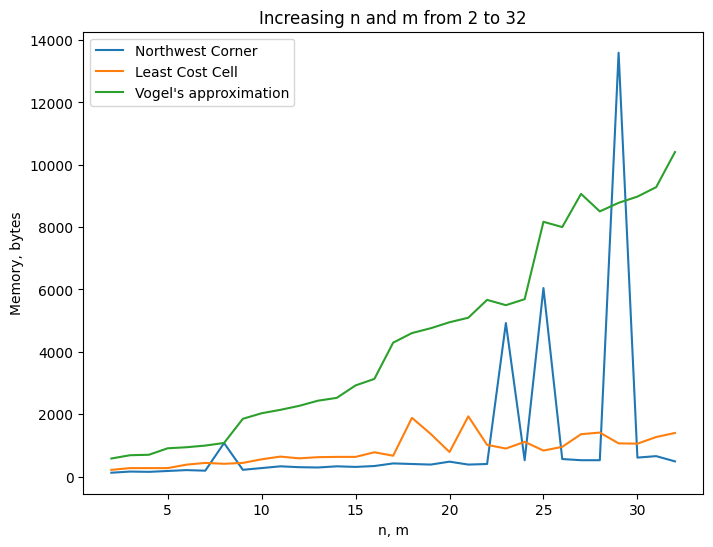

In [35]:
n_m_start = 2
n_m_end = 32

x = np.arange(n_m_start, n_m_end + 1, 1)

m1 = []
m2 = []
m3 = []


for n_m in range(n_m_start, n_m_end + 1, 1):
    n_tests = 3

    t_m1 = []
    t_m2 = []
    t_m3 = []

    i = 0
    while i < n_tests:
        grid, supply, demand = generate_transport_problem(
            n_m, n_m, cost_lim=15)

        m = []

        r1, loops_1, mem1 = northwest_corner(grid, supply, demand)
        m.append(mem1)

        r2, loops_2, mem2 = least_cost_cell(grid, supply, demand)
        m.append(mem2)

        r3, loops_3, mem3 = vogels_approximation(grid, supply, demand)
        m.append(mem3)

        if r2 == 0 or r3 == 0:
            continue

        print(m)

        t_m1.append(m[0])
        t_m2.append(m[1])
        t_m3.append(m[2])
        i += 1

    m1.append(np.mean(t_m1))
    m2.append(np.mean(t_m2))
    m3.append(np.mean(t_m3))

plt.figure(figsize=(8, 6))
plt.title('Increasing n and m from {} to {}'.format(n_m_start, n_m_end))

plt.plot(x, m1, label="Northwest Corner")
plt.plot(x, m2, label="Least Cost Cell")
plt.plot(x, m3, label="Vogel's approximation")
plt.xlabel('n, m')
plt.ylabel('Memory, bytes')
plt.legend()

plt.show()
